# **TF-IDF + SVD + SVM** 

## **prepare the evaluation function**

In [1]:
import random
random.seed(42)

In [2]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    hamming_loss,
    make_scorer
)
# ============================================================================
# EVALUATION FUNCTION
# ============================================================================
def evaluate_model(model, X_val, y_val, model_name="Model"):
    """Evaluate model and print metrics"""
    print(f"\n" + "=" * 60)
    print(f"EVALUATION: {model_name}")
    print("=" * 60)
    
    y_pred = model.predict(X_val).toarray()
    
    # Calculate metrics
    f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_val, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_val, y_pred)
    precision_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
    hamming = hamming_loss(y_val, y_pred)
    
    print(f"\nF1 Score (Macro):     {f1_macro:.4f}")
    print(f"F1 Score (Micro):     {f1_micro:.4f}")
    print(f"F1 Score (Weighted):  {f1_weighted:.4f}")
    print(f"Accuracy (Subset):    {accuracy:.4f}")
    print(f"Precision (Macro):    {precision_macro:.4f}")
    print(f"Recall (Macro):       {recall_macro:.4f}")
    print(f"Hamming Loss:         {hamming:.4f}")
    
    # Per-label F1 scores
    print(f"\nPer-Label F1 Scores:")
    f1_per_label = f1_score(y_val, y_pred, average=None, zero_division=0)
    for i, score in enumerate(f1_per_label):
        print(f"  Label {i}: {score:.4f}")
    
    return {
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'f1_weighted': f1_weighted,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'hamming_loss': hamming,
        'f1_per_label': f1_per_label
    }


## **Loading the prepared data**

In [3]:
f=8192
s=1024

In [4]:
import pandas as pd
import numpy as np

# Load features and labels
X_train = pd.read_csv(f"/kaggle/input/data-{f}-{s}/X_train.csv").values
y_train = pd.read_csv(f"/kaggle/input/data-{f}-{s}/y_train.csv").values

In [5]:
# Load features and labels
X_val = pd.read_csv(f"/kaggle/input/data-{f}-{s}/X_val.csv").values
y_val = pd.read_csv(f"/kaggle/input/data-{f}-{s}/y_val.csv").values

In [6]:
import pandas as pd
import numpy as np

# Load features and labels
X_test = pd.read_csv(f"/kaggle/input/data-{f}-{s}/X_test.csv").values
y_test = pd.read_csv(f"/kaggle/input/data-{f}-{s}/y_test.csv").values

In [7]:
from sklearn.model_selection import PredefinedSplit
X = np.vstack([X_train, X_val])
y = np.vstack([y_train, y_val])

test_fold = np.concatenate([
    -1 * np.ones(len(X_train)),  # training
     0 * np.ones(len(X_val))     # validation
])

ps = PredefinedSplit(test_fold)

## **coarse to fine for linear SVM**

### **coarse**

In [8]:
from skmultilearn.problem_transform import ClassifierChain
from cuml.svm import LinearSVC
from cuml.model_selection import GridSearchCV
# ============================================================================

print("\n" + "=" * 60)

# Defining hyperparameters list
coarse_param_grid = {
    'classifier__C': [0.1, 1, 10, 100]
}

# Create and train baseline model
base_svm11 = LinearSVC()

model11 = ClassifierChain(base_svm11)

grid11 = GridSearchCV(estimator = model11, 
             param_grid = coarse_param_grid,
             cv=ps,
             scoring = "accuracy"
            )
grid11.fit(X, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=ClassifierChain(classifier=LinearSVC(),
                                       require_dense=[True, True]),
             param_grid={'classifier__C': [0.1, 1, 10, 100]},
             scoring='accuracy')

In [9]:
import pandas as pd

results = pd.DataFrame(grid11.cv_results_)

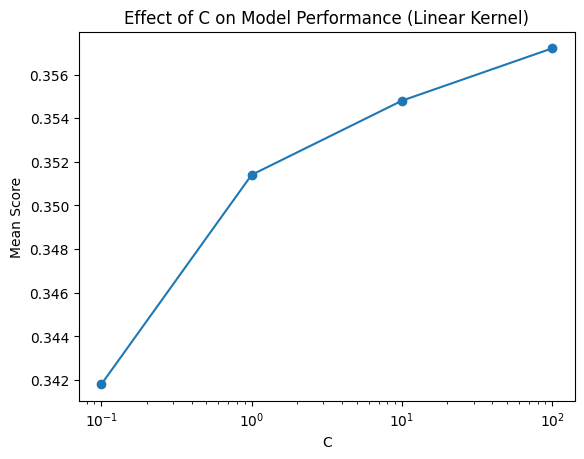

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    results["param_classifier__C"].astype(float),
    results["mean_test_score"],
    marker="o"
)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Score")
plt.title("Effect of C on Model Performance (Linear Kernel)")
plt.show()


### **fine**

In [11]:
from skmultilearn.problem_transform import ClassifierChain
from cuml.svm import LinearSVC
from cuml.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
# ============================================================================

print("\n" + "=" * 60)

# Defining hyperparameters list
best_C = float(grid11.best_params_['classifier__C'])

# Log-scale refinement around best C
fine_C = np.logspace(
    np.log10(best_C) - 1,
    np.log10(best_C) + 1,
    num=7
)

fine_C = np.unique(np.round(fine_C, 8)) 

fine_param_grid =  {
    'classifier__C': fine_C
}

# Create and train baseline model
base_svm12 = LinearSVC()

model12 = ClassifierChain(base_svm12)

grid12 = GridSearchCV(estimator = model12, 
             param_grid = fine_param_grid,
             cv=ps,
             scoring = "accuracy"
            )
grid12.fit(X, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=ClassifierChain(classifier=LinearSVC(),
                                       require_dense=[True, True]),
             param_grid={'classifier__C': array([  10.        ,   21.5443469 ,   46.41588834,  100.        ,
        215.443469  ,  464.15888336, 1000.        ])},
             scoring='accuracy')

In [12]:
import pandas as pd

results = pd.DataFrame(grid12.cv_results_)

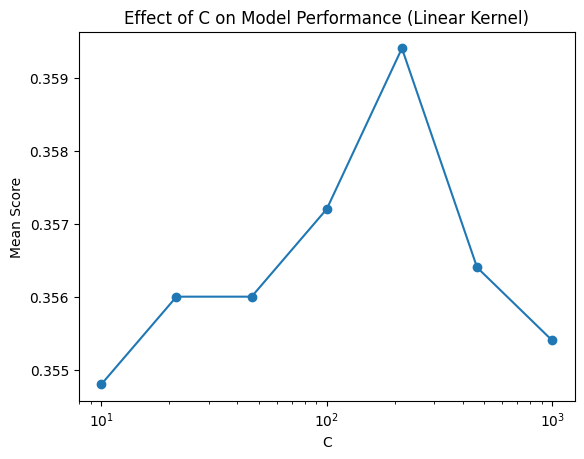

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    results["param_classifier__C"].astype(float),
    results["mean_test_score"],
    marker="o"
)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Score")
plt.title("Effect of C on Model Performance (Linear Kernel)")
plt.show()


In [14]:
best_model12 = grid12.best_estimator_

## **Evaluation of the LinearSVM results**

In [15]:
results = evaluate_model(best_model12, X_train, y_train)


EVALUATION: Model

F1 Score (Macro):     0.7111
F1 Score (Micro):     0.8323
F1 Score (Weighted):  0.8237
Accuracy (Subset):    0.4254
Precision (Macro):    0.8196
Recall (Macro):       0.6502
Hamming Loss:         0.0675

Per-Label F1 Scores:
  Label 0: 0.7201
  Label 1: 0.6026
  Label 2: 0.1897
  Label 3: 0.7634
  Label 4: 0.8963
  Label 5: 0.7277
  Label 6: 0.7228
  Label 7: 0.5990
  Label 8: 0.8049
  Label 9: 0.6581
  Label 10: 0.9692
  Label 11: 0.6864
  Label 12: 0.7532
  Label 13: 0.8625


In [16]:
results = evaluate_model(best_model12, X_val, y_val)


EVALUATION: Model

F1 Score (Macro):     0.7194
F1 Score (Micro):     0.8272
F1 Score (Weighted):  0.8212
Accuracy (Subset):    0.3794
Precision (Macro):    0.8022
Recall (Macro):       0.6654
Hamming Loss:         0.0759

Per-Label F1 Scores:
  Label 0: 0.7862
  Label 1: 0.8146
  Label 2: 0.3833
  Label 3: 0.8690
  Label 4: 0.8424
  Label 5: 0.5530
  Label 6: 0.7210
  Label 7: 0.6362
  Label 8: 0.8410
  Label 9: 0.5468
  Label 10: 0.9747
  Label 11: 0.5792
  Label 12: 0.6247
  Label 13: 0.8998


In [17]:
results = evaluate_model(best_model12, X_test, y_test)


EVALUATION: Model

F1 Score (Macro):     0.6875
F1 Score (Micro):     0.7945
F1 Score (Weighted):  0.7911
Accuracy (Subset):    0.2840
Precision (Macro):    0.7570
Recall (Macro):       0.6411
Hamming Loss:         0.0885

Per-Label F1 Scores:
  Label 0: 0.7431
  Label 1: 0.8022
  Label 2: 0.2548
  Label 3: 0.8375
  Label 4: 0.7949
  Label 5: 0.4684
  Label 6: 0.6625
  Label 7: 0.7020
  Label 8: 0.8015
  Label 9: 0.5433
  Label 10: 0.9665
  Label 11: 0.5333
  Label 12: 0.6374
  Label 13: 0.8782


## **coarse to fine for rbf SVM**

## **coarse**

In [18]:
from skmultilearn.problem_transform import ClassifierChain
from cuml.svm import SVC
from cuml.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
# ============================================================================

print("\n" + "=" * 60)

# Defining hyperparameters list
coarse_param_grid = {
    'classifier__kernel': ['rbf'],
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale','auto', 0.01, 0.1, 1]
}

# Create and train baseline model
base_svm21 = SVC(random_state=42)

model21 = ClassifierChain(base_svm21)

grid21 = GridSearchCV(estimator = model21, 
             param_grid = coarse_param_grid,
             cv=ps,
             scoring = "accuracy"
            )
grid21.fit(X, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=ClassifierChain(classifier=SVC(),
                                       require_dense=[True, True]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'classifier__kernel': ['rbf']},
             scoring='accuracy')

In [19]:
import pandas as pd

results = pd.DataFrame(grid21.cv_results_)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

C_vals = results["param_classifier__C"].astype(float)
gamma_vals = results["param_classifier__gamma"].astype(str)
scores = results["mean_test_score"]


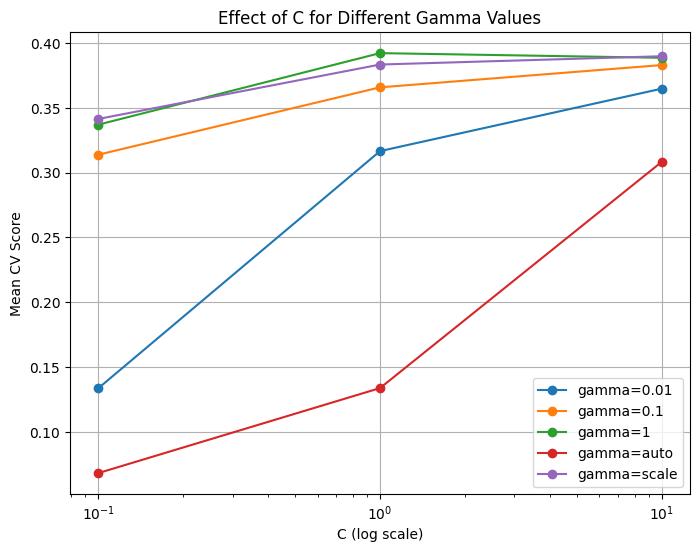

In [21]:
plt.figure(figsize=(8, 6))

for gamma in np.unique(gamma_vals):
    mask = gamma_vals == gamma

    plt.plot(
        C_vals[mask],
        scores[mask],
        marker="o",
        label=f"gamma={gamma}"
    )

plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("CV Score")
plt.title("Effect of C for Different Gamma Values")
plt.legend()
plt.grid(True)
plt.show()


## **fine**

In [22]:
best_params = grid21.best_params_
print(best_params)

{'classifier__C': 1, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}


In [23]:
from skmultilearn.problem_transform import ClassifierChain
from cuml.svm import SVC
from cuml.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
# ============================================================================

print("\n" + "=" * 60)

# Defining hyperparameters list
def refine_log_space(value, factors=(0.3, 0.6, 1.0, 1.5, 3.0)):
    return sorted(set([value * f for f in factors if value * f > 0]))

best_C = best_params['classifier__C']
best_gamma = best_params['classifier__gamma']

fine_param_grid = {
    'classifier__kernel': ['rbf'],
    'classifier__C': refine_log_space(best_C),
    'classifier__gamma': (
        ['scale'] if best_gamma == 'scale'
        else (['auto'] if best_gamma == 'auto' else refine_log_space(best_gamma))
    )
}


# Create and train baseline model
base_svm22 = SVC(random_state=42)

model22 = ClassifierChain(base_svm22)

grid22 = GridSearchCV(estimator = model22, 
             param_grid = fine_param_grid,
             cv=ps,
             scoring = "accuracy"
            )
grid22.fit(X, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=ClassifierChain(classifier=SVC(),
                                       require_dense=[True, True]),
             param_grid={'classifier__C': [0.3, 0.6, 1.0, 1.5, 3.0],
                         'classifier__gamma': [0.3, 0.6, 1.0, 1.5, 3.0],
                         'classifier__kernel': ['rbf']},
             scoring='accuracy')

In [28]:
best_model22 = grid22.best_estimator_

In [35]:
best_params = grid22.best_params_
print(best_params)

{'classifier__C': 1.5, 'classifier__gamma': 1.5, 'classifier__kernel': 'rbf'}


## **Evaluation of RBF SVM results**

In [29]:
results = evaluate_model(best_model22, X_train, y_train)


EVALUATION: Model

F1 Score (Macro):     0.8773
F1 Score (Micro):     0.9256
F1 Score (Weighted):  0.9242
Accuracy (Subset):    0.7189
Precision (Macro):    0.9257
Recall (Macro):       0.8383
Hamming Loss:         0.0308

Per-Label F1 Scores:
  Label 0: 0.8795
  Label 1: 0.8346
  Label 2: 0.7029
  Label 3: 0.9051
  Label 4: 0.9580
  Label 5: 0.9024
  Label 6: 0.8675
  Label 7: 0.8341
  Label 8: 0.9008
  Label 9: 0.8497
  Label 10: 0.9852
  Label 11: 0.8498
  Label 12: 0.8735
  Label 13: 0.9394


In [30]:
results = evaluate_model(best_model22, X_val, y_val)


EVALUATION: Model

F1 Score (Macro):     0.8695
F1 Score (Micro):     0.9212
F1 Score (Weighted):  0.9192
Accuracy (Subset):    0.6936
Precision (Macro):    0.9210
Recall (Macro):       0.8275
Hamming Loss:         0.0355

Per-Label F1 Scores:
  Label 0: 0.9041
  Label 1: 0.9122
  Label 2: 0.7570
  Label 3: 0.9429
  Label 4: 0.9564
  Label 5: 0.7956
  Label 6: 0.8576
  Label 7: 0.7997
  Label 8: 0.9108
  Label 9: 0.7603
  Label 10: 0.9895
  Label 11: 0.8561
  Label 12: 0.7745
  Label 13: 0.9563


In [31]:
results = evaluate_model(best_model22, X_test, y_test)


EVALUATION: Model

F1 Score (Macro):     0.7561
F1 Score (Micro):     0.8447
F1 Score (Weighted):  0.8409
Accuracy (Subset):    0.4696
Precision (Macro):    0.8310
Recall (Macro):       0.7017
Hamming Loss:         0.0674

Per-Label F1 Scores:
  Label 0: 0.8279
  Label 1: 0.8430
  Label 2: 0.5729
  Label 3: 0.8641
  Label 4: 0.9097
  Label 5: 0.6000
  Label 6: 0.7079
  Label 7: 0.7069
  Label 8: 0.8172
  Label 9: 0.6269
  Label 10: 0.9671
  Label 11: 0.6130
  Label 12: 0.6401
  Label 13: 0.8891


In [32]:
import joblib

joblib.dump(best_model22, "news_multilabel_model.joblib")

['news_multilabel_model.joblib']